In [1]:
import sys
import pickle
import csv
import pandas as pd
from ggplot import *
%matplotlib inline

In [2]:
sys.path.append("./tools")
sys.path.append("./final_project")

In [3]:
from util import create_csv

In [4]:
with open("final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [5]:
create_csv(data_dict, "final_project/final_project_data.csv")

In [6]:
data = pd.read_csv("final_project/final_project_data.csv")

In [7]:
data.shape

(146, 22)

In [8]:
data.head()

,to_messages,deferral_payments,expenses,poi,long_term_incentive,email_address,from_poi_to_this_person,deferred_income,restricted_stock_deferred,shared_receipt_with_poi,...,other,director_fees,bonus,total_stock_value,from_this_person_to_poi,restricted_stock,salary,name,total_payments,exercised_stock_options
0,807.0,NaN,94299.0,False,NaN,mark.metts@enron.com,38.0,NaN,NaN,702.0,...,1740.0,NaN,600000.0,585062.0,1.0,585062.0,365788.0,METTS MARK,1061827.0,NaN
1,NaN,1295738.0,11200.0,False,1586055.0,NaN,NaN,-1386055.0,NaN,NaN,...,2660303.0,NaN,1200000.0,10623258.0,NaN,3942714.0,267102.0,BAXTER JOHN C,5634343.0,6680544.0
2,NaN,NaN,78552.0,False,NaN,steven.elliott@enron.com,NaN,-400729.0,NaN,NaN,...,12961.0,NaN,350000.0,6678735.0,NaN,1788391.0,170941.0,ELLIOTT STEVEN,211725.0,4890344.0
3,764.0,NaN,NaN,False,NaN,bill.cordes@enron.com,10.0,NaN,NaN,58.0,...,NaN,NaN,NaN,1038185.0,0.0,386335.0,NaN,CORDES WILLIAM R,NaN,651850.0
4,1045.0,NaN,34039.0,True,1617011.0,kevin.hannon@enron.com,32.0,-3117011.0,NaN,1035.0,...,11350.0,NaN,1500000.0,6391065.0,21.0,853064.0,243293.0,HANNON KEVIN P,288682.0,5538001.0


There seems to be a lot of NaN values in the data itself. Let us check how many null values are present in every column.

In [9]:
data.isnull().sum()

to_messages                   60
deferral_payments            107
expenses                      51
poi                            0
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
deferred_income               97
restricted_stock_deferred    128
shared_receipt_with_poi       60
loan_advances                142
from_messages                 60
other                         53
director_fees                129
bonus                         64
total_stock_value             20
from_this_person_to_poi       60
restricted_stock              36
salary                        51
name                           0
total_payments                21
exercised_stock_options       44
dtype: int64

There are only 146 records in total of which 142 records have missing `loan_advances` value. There is no point including this feature in any kind of analysis. Also, `director_fees` and `restricted_stock_deferred` have a lot of missing values but these make sense in the context of data as not all employees are directors and not many people would have deferred the payment of their restricted stocks. Also, those employees who serve as director might be more susceptible to being person of interest in our context.

Next, let us look at the distribution of target labels

In [10]:
from collections import Counter
counter = Counter(data['poi'])
print counter.most_common(2)

[(False, 128), (True, 18)]


There are only 18 POIs in the dataset of the total 146 individuals.

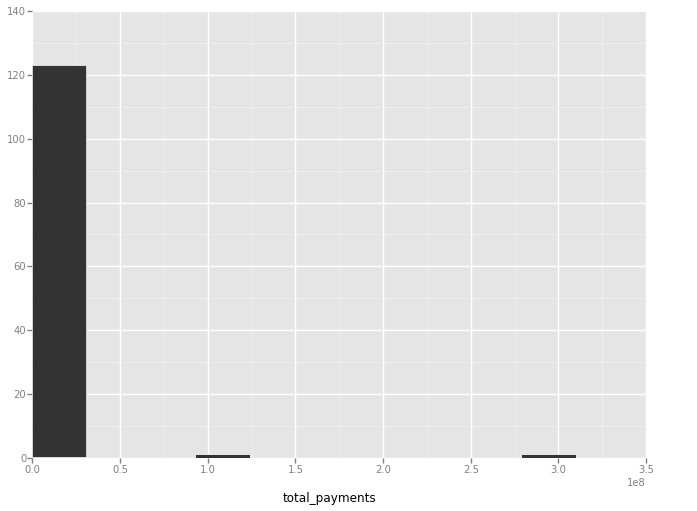

<ggplot: (12757333)>

In [11]:
ggplot(data, aes(x = 'total_payments')) + geom_histogram()

From the above histogram, there seems to be outliers to the far right of the distribution. Let us try to identify these outliers.

In [12]:
data[data['total_payments'] > 100000000]

,to_messages,deferral_payments,expenses,poi,long_term_incentive,email_address,from_poi_to_this_person,deferred_income,restricted_stock_deferred,shared_receipt_with_poi,...,other,director_fees,bonus,total_stock_value,from_this_person_to_poi,restricted_stock,salary,name,total_payments,exercised_stock_options
65,4273.0,202911.0,99832.0,True,3600000.0,kenneth.lay@enron.com,123.0,-300000.0,NaN,2411.0,...,10359729.0,NaN,7000000.0,49110078.0,16.0,14761694.0,1072321.0,LAY KENNETH L,103559793.0,34348384.0
104,NaN,32083396.0,5235198.0,False,48521928.0,NaN,NaN,-27992891.0,-7576788.0,NaN,...,42667589.0,1398517.0,97343619.0,434509511.0,NaN,130322299.0,26704229.0,TOTAL,309886585.0,311764000.0


From the above table, it is clear that these two data points refer to Kenneth Lay and probably a total column for all the points in the dataset given by the name 'TOTAL'. Let us remove the 'TOTAL' record from the dataset.

In [13]:
data = data[data['name'] != 'TOTAL']

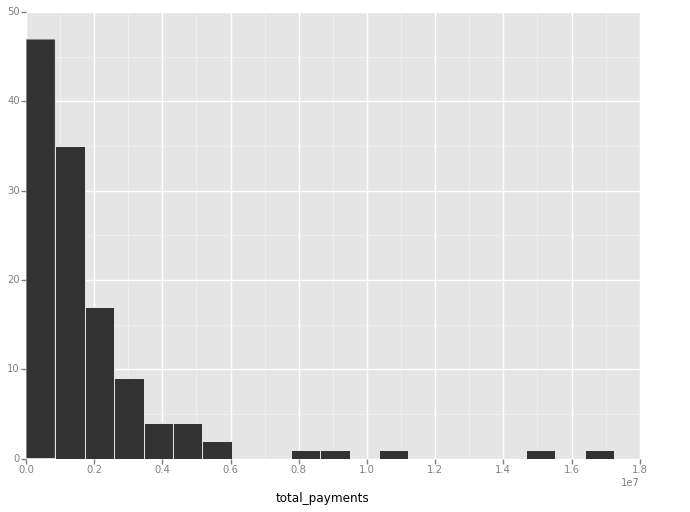

<ggplot: (17084346)>

In [14]:
ggplot(data[data['name'] != 'LAY KENNETH L'], aes(x = 'total_payments')) + geom_histogram(bins=20)

Even after excluding the data for 'TOTAL' and not plotting Kenneth Lay's total payments, the data for total payments is heavily right skewed.

Most of the numerical features would exhibit this skewed distribution because of the data being related to employees. The higher level employees (those belonging to CXO and director level) often have salaries and other components far greater than the low-level and mid-level executives.

Next let us eyeball the data for any other discrepancy that might be there in the data by opening the data in a spreadsheet.

After checking the data in the spreadsheet, we saw that there is an unusual employee in the list with `name` as 'THE TRAVEL AGENCY IN THE PARK' which does not seem to be any employee.

In [15]:
data[data['name'] == 'THE TRAVEL AGENCY IN THE PARK']

,to_messages,deferral_payments,expenses,poi,long_term_incentive,email_address,from_poi_to_this_person,deferred_income,restricted_stock_deferred,shared_receipt_with_poi,...,other,director_fees,bonus,total_stock_value,from_this_person_to_poi,restricted_stock,salary,name,total_payments,exercised_stock_options
101,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,362096.0,NaN,NaN,NaN,NaN,NaN,NaN,THE TRAVEL AGENCY IN THE PARK,362096.0,NaN


So, in our data analysis further, we must remove this entity too from our analysis.